In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import threading

import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision.transforms import v2
from torchvision.transforms.v2 import ToTensor
from torchvision import datasets
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
print(torch.cuda.device_count())
for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
device1 = torch.device("cuda:0")
device2 = torch.device("cuda:1")

2
GPU 0: Tesla T4
GPU 1: Tesla T4


In [3]:
transform_train = v2.Compose([
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomCrop(32, padding=4),
    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    v2.RandomRotation(15),
    ToTensor(),
    v2.Normalize(
        mean=[0.5071, 0.4867, 0.4408],
        std=[0.2675, 0.2565, 0.2761]
    )
])
transform_test = v2.Compose([
    ToTensor(),
    v2.Normalize(
        mean=[0.5071, 0.4867, 0.4408],
        std=[0.2675, 0.2565, 0.2761]
    )
])
trainset = datasets.CIFAR100(root = './data', train = True, download= True, transform = transform_train)
testset = datasets.CIFAR100(root = './data', train = False, download= True, transform = transform_test)

train_size = int(0.8* len(trainset))
valid_size = len(trainset) - train_size
trainset, validset = random_split(trainset, [train_size, valid_size])

train_loader = DataLoader(trainset, batch_size = 64, shuffle = True)
valid_loader = DataLoader(validset, batch_size = 64, shuffle = False)
test_loader = DataLoader(testset, batch_size = 64, shuffle = False)

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
100%|██████████| 169M/169M [00:08<00:00, 21.1MB/s]


In [4]:
def train_dataloader_model(
    model, train_loader, valid_loader, optim, loss_fn,
    device=None, max_epochs=100, diff=1e-3, patience=5, scheduler = None, name = None
):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)

    train_losses = []
    valid_losses = []
    valid_accuracies = []

    valid_loss_min = float("inf")
    patience_counter = 0

    for epoch in range(max_epochs):
        # ----------------------------
        # TRAINING PHASE
        # ----------------------------
        model.train()
        running_train_loss = 0.0

        for X_train, y_train in train_loader:
            X_train, y_train = X_train.to(device), y_train.to(device)

            optim.zero_grad()
            y_pred = model(X_train)
            loss = loss_fn(y_pred, y_train)
            loss.backward()
            optim.step()

            running_train_loss += loss.item()

        epoch_train_loss = running_train_loss / len(train_loader)
        train_losses.append(epoch_train_loss)

        # ----------------------------
        # VALIDATION PHASE
        # ----------------------------
        model.eval()
        running_valid_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for X_valid, y_valid in valid_loader:
                X_valid, y_valid = X_valid.to(device), y_valid.to(device)
                y_pred = model(X_valid)

                # Compute validation loss
                loss = loss_fn(y_pred, y_valid)
                running_valid_loss += loss.item()

                # Compute accuracy
                _, predicted = torch.max(y_pred, 1)
                correct += (predicted == y_valid).sum().item()
                total += y_valid.size(0)

        epoch_valid_loss = running_valid_loss / len(valid_loader)
        epoch_valid_acc = correct / total

        valid_losses.append(epoch_valid_loss)
        valid_accuracies.append(epoch_valid_acc)

        scheduler.step(epoch_valid_loss)
        # ----------------------------
        # EARLY STOPPING CHECKS
        # ----------------------------
        if epoch > 0 and abs(train_losses[-1] - train_losses[-2]) < diff:
            print(f"{name}|epoch {epoch}: loss diff < {diff} → early convergence.")
            break

        if epoch_valid_loss < valid_loss_min - diff:
            valid_loss_min = epoch_valid_loss
            patience_counter = 0
        else:
            patience_counter += 1

        print(
            f"{name}|Epoch [{epoch+1}/{max_epochs}] | "
            f"Train Loss: {epoch_train_loss:.4f} | "
            f"Valid Loss: {epoch_valid_loss:.4f} | "
            f"Valid Acc: {epoch_valid_acc*100:.2f}%"
        )

        if patience_counter >= patience:
            print(f"\nEarly stopping: no improvement for {patience} epochs.")
            break

    # ----------------------------
    # PLOTTING BEFORE RETURN
    # ----------------------------
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, valid_losses, label="Valid Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, valid_accuracies, label="Valid Accuracy", color="green")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Validation Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

## ResNeXt

In [5]:
class ResNeXtBlock(nn.Module):
    """The ResNeXt block."""
    def __init__(self,in_channels, out_channels, groups, bot_mul, use_1x1conv=False,
                 strides=1):
        super().__init__()
        bot_channels = int(round(out_channels * bot_mul))
        bot_channels = max(bot_channels, groups)
        self.conv1 = nn.Conv2d(in_channels, bot_channels, kernel_size=1, stride=1)
        self.bn1 = nn.BatchNorm2d(bot_channels)

        self.conv2 = nn.Conv2d(bot_channels, bot_channels, kernel_size=3,
                                   stride=strides, padding=1,
                                   groups=bot_channels//groups)
        self.bn2 = nn.BatchNorm2d(bot_channels)

        self.conv3 = nn.Conv2d(bot_channels, out_channels, kernel_size=1, stride=1)
        self.bn3 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        if use_1x1conv:
            self.conv4 = nn.Conv2d(in_channels, out_channels, kernel_size=1,
                                       stride=strides)
            self.bn4 = nn.BatchNorm2d(out_channels)
        else:
            self.conv4 = None

    def forward(self, X):
        Y = self.relu(self.bn1(self.conv1(X)))
        Y = self.relu(self.bn2(self.conv2(Y)))
        Y = self.bn3(self.conv3(Y))
        if self.conv4:
            X = self.bn4(self.conv4(X))
        return self.relu(Y + X)
class ResNeXt(nn.Module):
    def block(self, num_residuals, in_channel, out_channels,
              groups=32, bot_mul=0.25, first_block=False):
        blk = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
               blk.append(ResNeXtBlock(in_channel, out_channels,
                                    groups, bot_mul, use_1x1conv=True, strides=2))
            else:
                blk.append(ResNeXtBlock(out_channels, out_channels,
                                    groups, bot_mul))
            in_channel = out_channels
        return nn.Sequential(*blk)

    def __init__(self, arch, num_classes=100):
        super(ResNeXt, self).__init__()
        self.b1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        self.net = nn.Sequential(self.b1)
        for i, b in enumerate(arch):
            self.net.add_module(f'b{i+2}', self.block(*b, first_block=(i==0)))
        self.net.add_module('last', nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
            nn.Linear(512, num_classes)))
    def forward(self, x):
        return self.net(x)

class ResNeXt18(ResNeXt):
    def __init__(self, num_classes=100):
        super().__init__(((2, 64, 64), (2, 64, 128), (2, 128, 256), (2, 256, 512))
                         , num_classes)


## SE_ResNeXt




In [6]:
class SEBlock(nn.Module):
    def __init__(self, num_channels, r = 16):
        super().__init__()
        self.GlobalPooling = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(num_channels, num_channels//r)
        self.fc2 = nn.Linear(num_channels//r, num_channels)
        self.net = nn.Sequential(
            self.GlobalPooling,nn.Flatten(), self.fc1, nn.ReLU(), self.fc2, nn.Sigmoid()
        )
    def forward(self, x):
        y = self.net(x)
        y = y[:, :, None, None]
        return x * y
class SE_ResNeXtBlock(ResNeXtBlock):
    def __init__(self, in_channels, out_channels, groups, bot_mul, use_1x1conv=False,
                 strides=1):
        super().__init__(in_channels, out_channels, groups, bot_mul, use_1x1conv,
                 strides)
        self.se = SEBlock(out_channels)

    def forward(self, X):
        Y = self.relu(self.bn1(self.conv1(X)))
        Y = self.relu(self.bn2(self.conv2(Y)))
        Y = self.bn3(self.conv3(Y))
        if self.conv4:
            X = self.bn4(self.conv4(X))
        Y = self.se(Y)
        return self.relu(Y + X)
class SE_ResNeXt(ResNeXt):
    def block(self, num_residuals, in_channel, out_channels,
              groups=32, bot_mul=0.25, first_block=False):
        blk = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
               blk.append(SE_ResNeXtBlock(in_channel, out_channels,
                                    groups, bot_mul, use_1x1conv=True, strides=2))
            else:
                blk.append(SE_ResNeXtBlock(out_channels, out_channels,
                                    groups, bot_mul))
            in_channel = out_channels
        return nn.Sequential(*blk)
    def __init__(self, arch, num_classes=100):
        super().__init__(arch, num_classes)
class SE_ResNeXt18(SE_ResNeXt):
    def __init__(self, num_classes=100):
        super().__init__(((2, 64, 64), (2, 64, 128), (2, 128, 256), (2, 256, 512))
                         , num_classes)

In [7]:
model1 = ResNeXt18().to(device1)
optim1 = torch.optim.Adam(model1.parameters(), lr=1e-3, weight_decay = 1e-4)
model2 = SE_ResNeXt18().to(device2)
optim2 = torch.optim.Adam(model2.parameters(), lr=1e-3, weight_decay = 1e-4)
loss_fn = nn.CrossEntropyLoss()
scheduler1 = ReduceLROnPlateau(optim1, mode='min', factor=0.5, patience=3)
scheduler2 = ReduceLROnPlateau(optim2, mode='min', factor=0.5, patience=3)

In [8]:
total_params1 = sum(p.numel() for p in model1.parameters())
print(f"Total parameters of model1: {total_params1:,}")
total_params2 = sum(p.numel() for p in model2.parameters())
print(f"Total parameters of model2: {total_params2:,}")

Total parameters of model1: 693,476
Total parameters of model2: 782,556


model1|Epoch [1/100] | Train Loss: 3.9605 | Valid Loss: 3.5925 | Valid Acc: 13.70%
model2|Epoch [1/100] | Train Loss: 3.8033 | Valid Loss: 3.4805 | Valid Acc: 16.40%
model1|Epoch [2/100] | Train Loss: 3.4212 | Valid Loss: 3.3687 | Valid Acc: 18.09%
model2|Epoch [2/100] | Train Loss: 3.2229 | Valid Loss: 3.0983 | Valid Acc: 22.77%
model1|Epoch [3/100] | Train Loss: 3.1406 | Valid Loss: 3.0575 | Valid Acc: 23.82%
model2|Epoch [3/100] | Train Loss: 2.9385 | Valid Loss: 2.9122 | Valid Acc: 27.09%
model1|Epoch [4/100] | Train Loss: 2.9284 | Valid Loss: 2.8937 | Valid Acc: 26.78%
model2|Epoch [4/100] | Train Loss: 2.7354 | Valid Loss: 2.7418 | Valid Acc: 30.59%
model1|Epoch [5/100] | Train Loss: 2.7683 | Valid Loss: 2.8561 | Valid Acc: 27.48%
model2|Epoch [5/100] | Train Loss: 2.5792 | Valid Loss: 2.6065 | Valid Acc: 33.01%
model1|Epoch [6/100] | Train Loss: 2.6440 | Valid Loss: 2.6671 | Valid Acc: 31.74%
model2|Epoch [6/100] | Train Loss: 2.4610 | Valid Loss: 2.5204 | Valid Acc: 34.27%
mode

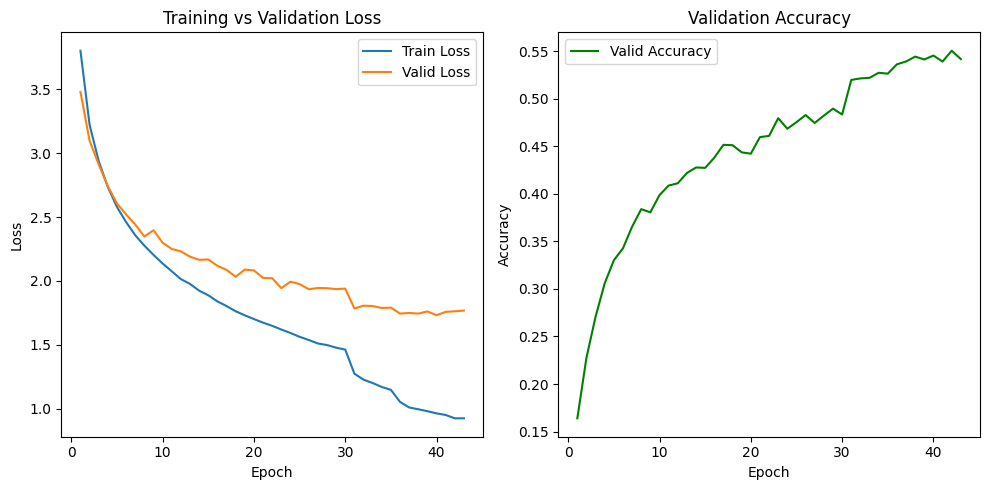

model1|Epoch [44/100] | Train Loss: 1.1038 | Valid Loss: 1.8108 | Valid Acc: 52.24%
model1|Epoch [45/100] | Train Loss: 1.0872 | Valid Loss: 1.8279 | Valid Acc: 52.44%
model1|Epoch [46/100] | Train Loss: 1.0741 | Valid Loss: 1.8046 | Valid Acc: 52.51%
model1|Epoch [47/100] | Train Loss: 0.9833 | Valid Loss: 1.7377 | Valid Acc: 54.76%
model1|Epoch [48/100] | Train Loss: 0.9460 | Valid Loss: 1.7340 | Valid Acc: 54.20%
model1|Epoch [49/100] | Train Loss: 0.9214 | Valid Loss: 1.7555 | Valid Acc: 54.75%
model1|Epoch [50/100] | Train Loss: 0.9113 | Valid Loss: 1.7269 | Valid Acc: 54.45%
model1|Epoch [51/100] | Train Loss: 0.9001 | Valid Loss: 1.7589 | Valid Acc: 54.69%
model1|Epoch [52/100] | Train Loss: 0.8872 | Valid Loss: 1.7286 | Valid Acc: 55.02%
model1|Epoch [53/100] | Train Loss: 0.8802 | Valid Loss: 1.7481 | Valid Acc: 54.42%
model1|Epoch [54/100] | Train Loss: 0.8736 | Valid Loss: 1.7717 | Valid Acc: 54.49%
model1|Epoch [55/100] | Train Loss: 0.8136 | Valid Loss: 1.7364 | Valid Acc:

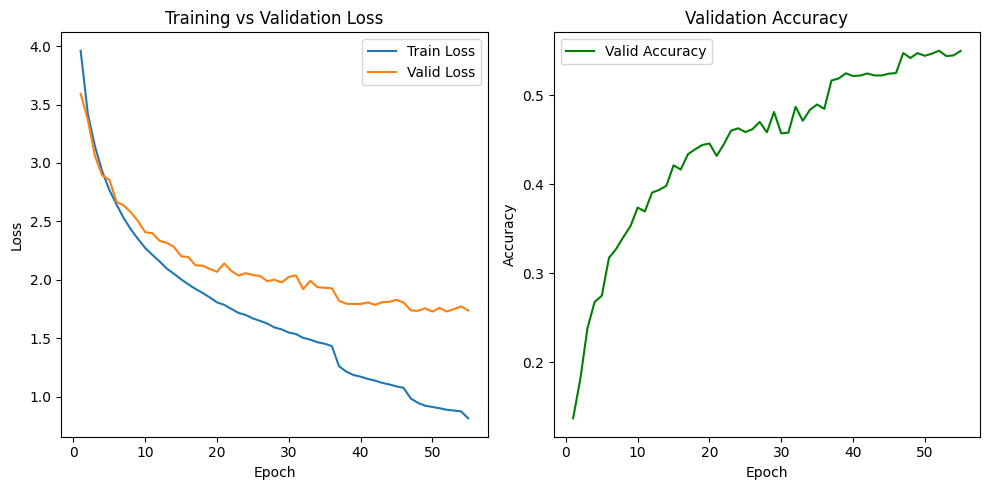

In [9]:
t1 = threading.Thread(
    target=train_dataloader_model,
    args=(model1, train_loader, valid_loader),
    kwargs={
        'optim': optim1,
        'loss_fn': loss_fn,
        'scheduler': scheduler1,
        'name': 'model1'
    }
)

t2 = threading.Thread(
    target=train_dataloader_model,
    args=(model2, train_loader, valid_loader),
    kwargs={
        'optim': optim2,
        'loss_fn': loss_fn,
        'scheduler': scheduler2,
        'name': 'model2'
    }
)
t1.start()
t2.start()

t1.join()
t2.join()

In [10]:
model1.eval()
with torch.no_grad():
    epoch_test_loss = 0.0
    correct = 0
    total = 0

    for X_test, y_test in test_loader:
        X_test, y_test = X_test.to(device1), y_test.to(device1)
        y_test_pred = model1(X_test)

        # Compute loss
        loss = loss_fn(y_test_pred, y_test)
        epoch_test_loss += loss.item()

        # Compute accuracy
        _, predicted = torch.max(y_test_pred, 1)
        correct += (predicted == y_test).sum().item()
        total += y_test.size(0)

    epoch_test_loss /= len(test_loader)
    test_accuracy = correct / total * 100

print(f"Test Loss: {epoch_test_loss:.4f} | Test Accuracy: {test_accuracy:.2f}%")

Test Loss: 1.5862 | Test Accuracy: 59.21%


In [11]:
model2.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for X_test, y_test in test_loader:
        X_test, y_test = X_test.to(device1), y_test.to(device1)
        y_pred = model2(X_test)

        # Compute batch loss
        loss = loss_fn(y_pred, y_test)
        test_loss += loss.item()

        # Compute batch accuracy
        _, predicted = torch.max(y_pred, 1)
        correct += (predicted == y_test).sum().item()
        total += y_test.size(0)

# Average loss per batch
test_loss /= len(test_loader)
test_acc = correct / total * 100

print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.2f}%")


Test Loss: 1.5948 | Test Accuracy: 59.34%
